##### Possible Parameters:
- starting line * 
    - intelligent way to pick this slope?

- number of iterations *

- starting PT on the starting line (& thus subsequent lines)
    - intelligent way to pick the starting pt?

In [1]:
import fiona

In [2]:
import shapely
from shapely import geometry
import math
shapely.__file__
#from osgeo import gdal, ogr, osr

#import fiona # need to install from src in order for buffering to work. see: https://github.com/geoplex/elasticsearch-spatial/issues/1
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../../alg')
import distance_buffer as db

# NOTE : if you still have trouble with fiona, add GDAL to path : https://tilemill-project.github.io/tilemill/docs/guides/gdal/

In [3]:
import geopandas
import osmnx as ox

In [13]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [19]:
import numpy as np

In [20]:
def gen_rand_pt(lo, hi):
    return ((lo - hi) * np.random.random() + hi)

In [21]:
# Note : this method will just pick the first rand pt found in the region
def gen_rand_pt_on_line(pt1, pt2, vec, region):
    pt = []
    mag = db.eucdist(pt1[0], pt1[1], pt2[0], pt2[1])
    randdist = gen_rand_pt(0, mag[0])
    randptp = pt1 + randdist*vec
    randptn = pt1 - randdist*vec
    randptp2 = pt2 + randdist*vec
    randptn2 = pt2 - randdist*vec

    if region.contains(geometry.Point(randptp)):
        pt = randptp
    elif region.contains(geometry.Point(randptn)):
        pt = randptn
    elif region.contains(geometry.Point(randptp2)):
        pt = randptp2
    elif region.contains(geometry.Point(randptn2)):
        pt = randptn2
    else:
        print "contains none...."
    #randptn = pt1 - randdist*vec
    #if 
    return pt

In [22]:
def gen_starting_line(bounds):
    # randomly pick 2 pts in area then get unit vector of that line
    pt1 = (gen_rand_pt(bounds[0],bounds[2]),gen_rand_pt(bounds[1],bounds[3]))
    pt2 = (gen_rand_pt(bounds[0],bounds[2]),gen_rand_pt(bounds[1],bounds[3]))
    # this switch doesnt really make a difference
    temp = pt2
    pt2 = np.array(pt1)
    pt1 = np.array(temp)
    v = pt2 - pt1
    line = v/np.linalg.norm(v)
    # TODO : vvv change this to a while loop
    #line = []
    #if not ((pt1[0]==pt2[0]) and (pt1[1]==pt2[1])):
    #    v = pt2 - pt1
    #    line = v / np.linalg.norm(v)
    #else:
    #    line = gen_starting_line(bounds)
    return line, pt1,pt2
    

In [241]:
def gen_cand_pts_on_line(poly, linevec, startpt, r):
    #main algorithm, start from the randomly generated intersecting line & then 
    # keeps track of running missed pts; stop once we get to a thresh
    
    eps = 0.01 # epsilon for tolerance of intersection of region and coverage area(r)
    covarea = math.pi*r*r
    nummissedpts = 0
    pt = startpt
    candpts = []
    tempregion = poly
    regiondiff = poly.difference(geometry.Point(startpt).buffer(r))
    bordercands = []
    lastpt = startpt
    if regiondiff.area < tempregion.area:
        candpts.append(startpt)
    optdist = math.sqrt(3)*r
            
    tempregion = regiondiff
    while nummissedpts < 50:
            temppt = pt + optdist*linevec
            pt = temppt
            regiondiff = tempregion.difference(geometry.Point(pt).buffer(r))
            rdarea = regiondiff.area
            trarea = tempregion.area
            if rdarea < trarea:
                candpts.append(temppt)
                tempregion = regiondiff
                nummissedpts = 0
                lastpt = temppt
                #if (trarea - rdarea) < covarea:
                    # this means the new candpt's covarea is on a border/hole
                #    bordercands.append(temppt)
            else:
                nummissedpts+=1
                
    
    
    #print "MOVE TO NEG DIR PT LOOP "+ str(len(candpts))
    
    
    nummissedpts = 0
    pt = startpt
    tempregion = regiondiff
    while nummissedpts < 50:
            temppt = pt - optdist*linevec
            pt = temppt
            regiondiff = tempregion.difference(geometry.Point(pt).buffer(r))
            rdarea = regiondiff.area
            trarea = tempregion.area
            if rdarea < trarea:
                candpts.append(temppt)
                tempregion = regiondiff
                nummissedpts = 0
                lastpt = temppt
                #if (trarea - rdarea) < covarea:
                    # this means the new candpt's covarea is on a border/hole
                #    bordercands.append(temppt)
            else:
                nummissedpts+=1
    
    
    #positive direction loop
    #while nummissedpts < 100:
    #    temppt = pt + optdist*linevec
    #    pt = temppt
    #    area = (poly.intersection(geometry.Point(pt).buffer(r))).area
    #    #if poly.contains(geometry.Point(temppt)):
    #    if area > eps:
    #       candpts.append(temppt)
    #       nummissedpts = 0
    #    else:
    #        nummissedpts+=1
            
            
    #nummissedpts = 0
    #pt = startpt
    #while nummissedpts < 100:
    #    temppt = pt - optdist*linevec
    #    pt = temppt
    #    area = (poly.intersection(geometry.Point(pt).buffer(r))).area
    #    
    #    if area > eps:
    #        candpts.append(temppt)
    #        nummissedpts = 0
    #    else:
    #        nummissedpts+=1

   
    return candpts, bordercands#, tempregion
    

In [234]:
def gen_cand_pts(poly, startvec, startpt, r):
    nummissedlines = 0
    candpts = []
    borderpts = []
    nextstpt = startpt
    #tempregions = []
    tempregion = poly
    #positive direction loop
    while nummissedlines < 100:
        temppts, tempbpts = gen_cand_pts_on_line(tempregion, startvec, nextstpt, r)
        if len(temppts) > 1:
            candpts.append(temppts)
            borderpts.append(tempbpts)
            #tempregions.append(tempregion)
            nextstpt = gen_next_line_startpt(nextstpt, startvec, r)
            nummissedlines=0
        else:
            nummissedlines+=1
            
    nummissedlines=0
    
    #print "MOVE TO NEG DIR LINE LOOP "+ str(len(tempregions))
    nextstpt = gen_next_line_startpt(startpt, startvec, -1*r)
    while nummissedlines < 100:
        temppts, tempbpts = gen_cand_pts_on_line(tempregion, startvec, nextstpt, r)
        if len(temppts) > 1:
            candpts.append(temppts)
            borderpts.append(tempbpts)
            #tempregions.append(tempregion)
            nextstpt = gen_next_line_startpt(nextstpt, startvec, -1*r)
            nummissedlines=0
        else:
            nummissedlines+=1     
    return candpts, borderpts#, tempregions
            

In [235]:
def gen_next_line_startpt(startpt, linevec, r):
    perpvec = [-linevec[1], linevec[0]]
    perpdist = (1.5)*r
    pardist = (math.sqrt(3)/2.0)*r
    temppt = startpt + perpdist*np.array(perpvec)
    newstartpt = temppt + pardist*linevec
    return newstartpt

In [236]:
# line[0] is starting pt, line[1] endpt; poly is a ring
def intersect_line_region(pt1,linevec, poly):
    
    intpt = []
    i = 1
    while len(intpt) < 2:
    #    # the line is a unit vector, get it long enough to make sure it intersects before we return the pt
        temp1 = pt1+ (100000.0*i)*linevec
        temp2 = pt1 - (100000.0*i)*linevec
        newline = geometry.LineString([temp1,temp2])
        intpt = newline.intersection(poly)
        i+=1
    
    return geometry.LineString(intpt)

In [55]:
def analyze_coverage(origpoly, candpts, r):
    
    
    return results
    

In [56]:
# Polygon to be covered, num of iterations to run algorithm, r = coverage radius
def marching_army(poly, numiter, r): #should there be some kind of variance parameter?
    
    # candptset[x] contains the candpts found for that in iter x; likewise for results[x]
    candptsets = []
    results = []
    
    for i in range(0, numiter):
        bds = poly.bounds
        line = gen_starting_line(bds)
        candptsets.append(gen_cand_pts(poly, startline, r))
        results.append(analyze_coverage(poly, candptsets[i], r))
    
    return candptsets, results

### Read in the shapefile and get the polygon that we're going to work with

In [57]:
shp = fiona.open("../../../data/YukonAlaska/YukonRegionCRS.shp")
l = iter(shp) # get the list of geoms from the shapefile 
first = next(l)
shp_geom = shapely.geometry.shape(first['geometry'])

# This is a sufficiently irregular shape so we will go with this one
region = shp_geom
print len(region.exterior.coords)
print len(region.interiors)
print region.area
region
print region.bounds

183
0
4918771.66688
(-631535.6236662696, 1321572.2678891697, -630132.1088717761, 1327921.5599169973)


### Run marching army algorithm on the polygon

In [58]:
candptsets, coverresults = marching_army(region, 1000)

TypeError: marching_army() takes exactly 3 arguments (2 given)

### START here

In [157]:
bounds = region.bounds
start_line, pt1,pt2 = gen_starting_line(bounds)
print start_line
print pt1,pt2


[-0.29893721  0.95427278]
[ -630276.52103375  1323281.33992394] [ -630837.07417386  1325070.74784894]


In [158]:
intpt = intersect_line_region(pt1, start_line, region.exterior)
print intpt

LINESTRING (-631348.4017293263 1326703.016967662, -630330.9648954396 1323455.136609045)


In [183]:
randpts = gen_rand_pt_on_line(pt1, pt2, start_line, region)
print randpts

[ -630865.40111515  1325161.17362591]


In [184]:
print start_line

[-0.29893721  0.95427278]


In [185]:
candpts1, treg1 = gen_cand_pts_on_line(region, start_line,randpts, 100.0)


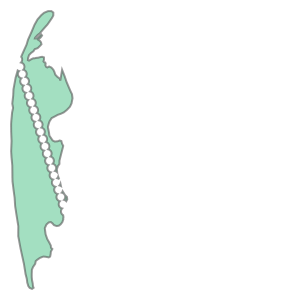

In [186]:
treg1

In [213]:
nextstpt = gen_next_line_startpt(randpts, start_line, 100.0)
nextstptneg = gen_next_line_startpt(randpts, start_line, -100.0)

print randpts, nextstpt

[ -630865.40111515  1325161.17362591] [ -631034.43075426  1325198.97549232]


In [188]:
candpts2, treg2 = gen_cand_pts_on_line(region, start_line, nextstpt, 100.0)

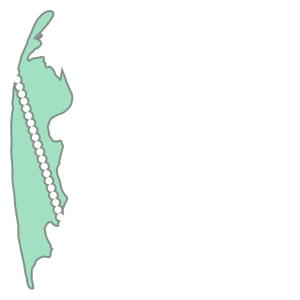

In [190]:
treg2

In [ ]:
#CPU times: user 3min 52s, sys: 396 ms, total: 3min 53s
#Wall time: 3min 53s
# REALLY slow when we return the temporary regions - check without that

In [242]:

%%time
candptsalltry1, borderpts = gen_cand_pts(region, start_line, randpts, 100.0)


CPU times: user 9.57 s, sys: 17.6 ms, total: 9.59 s
Wall time: 9.6 s


In [243]:
print len(candptsalltry1)

17


In [244]:
print len(borderpts)

17


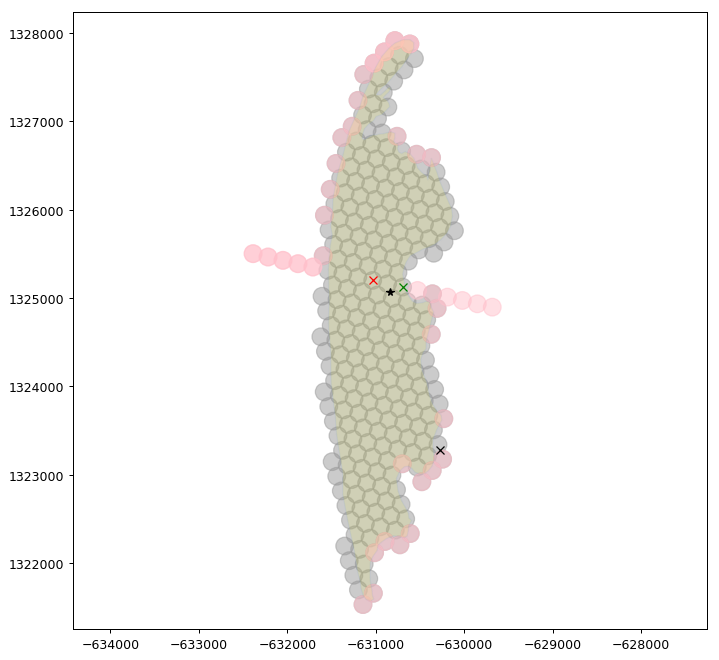

In [245]:
ax, fig = db.plot_fig(region)
#db.plot_line(ax, intpt.coords,ls='-',color='red',zorder=2)
#temp = zip(*randpts)
ax.plot(pt1[0], pt1[1], 'x', color="black")
ax.plot(pt2[0], pt2[1], '*', color="black")
ax.plot(nextstpt[0], nextstpt[1], 'x', color='red')
ax.plot(nextstptneg[0], nextstptneg[1], 'x', color='green')

#db.plot_radii(ax, zip(*candpts1),100.0)
tcandpts1 = zip(*candpts1)
tcandpts2 = zip(*candpts2)
#ax.plot(tcandpts1[0], tcandpts1[1], 'o',ms=0.2, color='pink')
#db.plot_radii(ax, candpts1, 100.0, alpha=0.5)
#db.plot_radii(ax, candpts2, 100.0, alpha=0.5)
#ax.plot(negpt[0], negpt[1], 'o', color='purple')
for i in range(0, len(candptsalltry1)):
    db.plot_radii(ax, candptsalltry1[i], 100.0, alpha=0.5)
    
for i in range(0, len(borderpts)):
    db.plot_radii(ax, borderpts[i], 100.0, alpha=0.5, color="pink")
#ax.plot(candptsalltry1[9][0][0], candptsalltry1[9][0][1], 'o', color='green', alpha=0.5)
#ax.plot(candptsalltry1[0][0][0], candptsalltry1[0][0][1], 'o', color='purple', alpha=0.5)

pyplot.show()

In [283]:
geometry.Point(candptsalltry1[0][0]).buffer(100.0, resolution=32).intersection(geometry.Point(candptsalltry1[0][1]).buffer(100.0, resolution=16)).area/abc

0.9942585924196763

In [284]:
(geometry.Point(candptsalltry1[0][1]).buffer(1, resolution=16)).area/(math.pi*1*1)

0.9983943930307164

In [257]:
math.pi

3.141592653589793

In [281]:
 abc=(((math.pi/6)-(math.sqrt(3)/4))*100*100*2)

In [208]:
tempregs[7].area

1607684.7151542834

In [15]:
region.intersection(geometry.Point([-633000,1326000]).buffer(100.0)).area


0.0

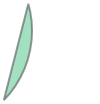

In [515]:
(region.intersection(geometry.Point(candptsalltry1[6][1]).buffer(100.0)))

In [466]:
for i in range(0, len(candptsalltry1)):
    print candptsalltry1[i][0]

[ -630912.50646191  1325438.44292009]
[ -631058.95734959  1325530.92068769]
[ -631205.40823726  1325623.39845529]
[ -631351.85912493  1325715.87622289]
[ -631498.3100126   1325808.35399049]
[ -630912.50646191  1325438.44292009]
[ -630766.05557424  1325345.96515249]
[ -630619.60468657  1325253.4873849 ]
[ -630473.1537989  1325161.0096173]
[ -630326.70291122  1325068.5318497 ]
[ -630180.25202355  1324976.0540821 ]


In [475]:
db.eucdist(candptsalltry1[5][0][0], candptsalltry1[5][0][1], candptsalltry1[0][0][0], candptsalltry1[0][0][1])

[0.0, 0.0, 0.0]

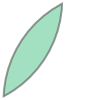

In [416]:
(geometry.Point(candpts1[0]).buffer(100.0)).intersection(geometry.Point(candpts2[0]).buffer(100.0))

In [66]:
p =np.array([1,2])
print p

[1 2]


In [224]:
bounds = region.bounds
pt1 = np.array([gen_rand_pt(bounds[0],bounds[2]), gen_rand_pt(bounds[1],bounds[3])])
pt2 = np.array([gen_rand_pt(bounds[0], bounds[2]), gen_rand_pt(bounds[1], bounds[3])])
line = []
if not ((pt1[0]==pt2[0]) and (pt1[1]==pt[1])):
    v = pt2 - pt1
    line = v / np.linalg.norm(v)

    print line
print bounds
print pt1, pt2

[ 0.26967216 -0.96295219]
(-631535.6236662696, 1321572.2678891697, -630132.1088717761, 1327921.5599169973)
[ -630988.49830285  1326571.68047753] [ -630542.89201829  1324980.4982268 ]


In [134]:
vecpt1 = line*1000000.0
vecpt2 = line*-1000000.0

vecline = geometry.LineString([vecpt1, vecpt2])
intpt2 = vecline.intersection(region.exterior)

In [135]:
print vecline
print intpt2

LINESTRING (342248.505310455 -939609.4723941215, -342248.505310455 939609.4723941215)
GEOMETRYCOLLECTION EMPTY


In [136]:
linepts = geometry.LineString([pt1,pt2])
intpt = linepts.intersection(region.exterior)
print intpt

GEOMETRYCOLLECTION EMPTY


In [137]:
print linepts
print intpt


LINESTRING (-631290.9326336206 1324783.839110376, -630727.1346371475 1323235.987389234)
GEOMETRYCOLLECTION EMPTY


In [141]:
temp1 = pt1+ 100000.0*line
temp2 = pt1 - 100000.0*line
try3 = geometry.LineString([temp1,temp2])
intpt3 = try3.intersection(region.exterior)
print try3
print intpt3

LINESTRING (-597066.0821025751 1230822.891870964, -665515.783164666 1418744.786349788)
MULTIPOINT (-631528.5002035924 1325436.05741262, -630674.6334533931 1323091.850574019)


In [214]:
# convert from multipoint to a linestring for plotting
print list(intpt3.geoms)
linetry3 = geometry.LineString(intpt3)

[<shapely.geometry.point.Point object at 0x10da68050>, <shapely.geometry.point.Point object at 0x10d1ac110>]


In [163]:
print linetry3

LINESTRING (-631528.5002035924 1325436.05741262, -630674.6334533931 1323091.850574019)


## Plot the figure

In [210]:
ax, fig = db.plot_fig(region)

[(-631528.5002035924, 1325436.0574126197), (-630674.6334533931, 1323091.8505740194)]


In [212]:
db.plot_line(ax, linetry3.coords,ls='-',color='red',zorder=2)

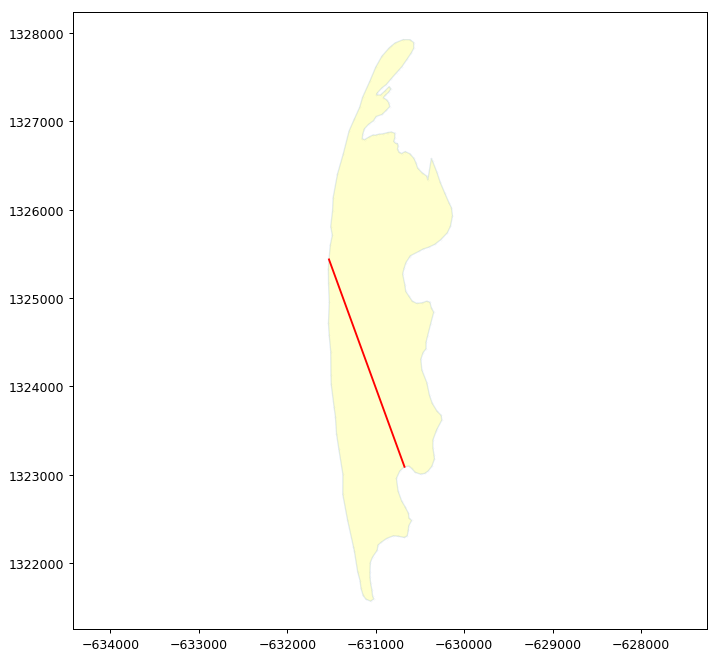

In [213]:
pyplot.show()